<a href="https://colab.research.google.com/github/SmitaPaul7000/CaseStudies/blob/master/1.0%20Image%20Captioning/Code/XX_VGG16_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Version

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Import Data

In [0]:
#Import Necessary Libraries
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from PIL import Image
import string
from pickle import load

from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [0]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    #print(model.summary())
    # re-structure the model

    # remove last output layer from vgg16
    model.layers.pop()
    # print(model.summary())

    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    #print(model.summary())

    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name

        # for loading an image from file as a PIL image object.
        image = load_img(filename, target_size=(224, 224))
        #print(image)

        # convert the image pixels to a numpy array
        image = img_to_array(image)
        #print(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        #print(image)

        # prepare the image for the VGG model
        image = preprocess_input(image)
        #print("1.2")
        #print(image)

        # get features
        feature = model.predict(image, verbose=0)
        #print("1.3")
        #print(feature)
        #print(feature.shape)
    
        # get image id
        image_id = name.split('.')[0]
        #print(image_id)
        # store feature
        features[image_id] = feature
        # print('>%s' % name)
        #break
    return features



In [97]:
# extract features from all images
directory = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

Extracted Features: 8091


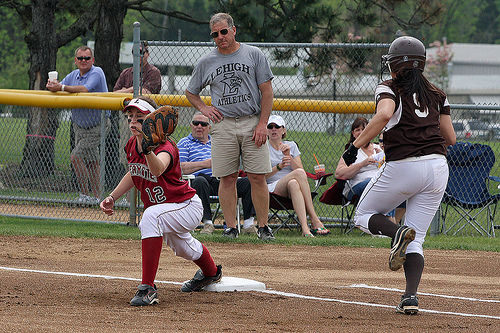

In [21]:
Image.open('/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/3517040752_debec03376.jpg')

In [27]:
features['3517040752_debec03376'].shape
#features[''] 

(1, 4096)

In [0]:
# save to file
dump(features, open('features.pkl', 'wb'))

#### open file which have image id and desciption

In [0]:
#Flickr8k.token.txt contain image id and 3-4 line description for image
filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr8k.token.txt'

# load descriptions
file = open(filename, 'r')
doc = file.read()
file.close() 

# # parse descriptions
#descriptions = load_descriptions(doc)
# print('Loaded: %d ' % len(descriptions))
# # clean descriptions
# clean_descriptions(descriptions)
# # summarize vocabulary
# vocabulary = to_vocabulary(descriptions)
# print('Vocabulary Size: %d' % len(vocabulary))
# # save to file
# save_descriptions(descriptions, 'descriptions.txt')

#### Create dictionary with image id and image description



In [0]:
mapping = dict()
#i = 1
# process lines
for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  if len(line) < 2:
    continue
  # take the first token as the image id, the rest as the description
  image_id, image_desc = tokens[0], tokens[1:]
  # remove filename from image id
  image_id = image_id.split('.')[0]
  # convert description tokens back to string
  image_desc = ' '.join(image_desc)
  
  # create the list if needed, else appende description to existing image id
  if image_id not in mapping:
    mapping[image_id] = list()
    # store description
  mapping[image_id].append(image_desc)    
  #i = i+1
  #if i==10 :
  #  break
descriptions =mapping

#### Text preprocessing, cleaning up data

In [0]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
  for i in range(len(desc_list)):
    desc = desc_list[i]
    # tokenize
    desc = desc.split()
    # convert to lower case
    desc = [word.lower() for word in desc]
    # remove punctuation from each token
    desc = [w.translate(table) for w in desc]
    # remove hanging 's' and 'a'
    desc = [word for word in desc if len(word)>1]
    # remove tokens with numbers in them
    desc = [word for word in desc if word.isalpha()]
    # store as string
    desc_list[i] =  ' '.join(desc)

#### convert the loaded descriptions (text) into a vocabulary of words

In [0]:
# build a list of all description strings
all_desc = set()
for key in descriptions.keys():
  [all_desc.update(d.split()) for d in descriptions[key]]


#### save descriptions to file, one per line


In [0]:
# save descriptions to file, one per line
lines = list()
for key, desc_list in descriptions.items():
  for desc in desc_list:
    lines.append(key + ' ' + desc)
data = '\n'.join(lines)
file = open('descriptions.txt', 'w')
file.write(data)
file.close()

# Train on Flickr_8k.trainImages.txt

#### Get Train Images on list 

In [0]:
# load a pre-defined list of photo identifiers
filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.trainImages.txt'
file = open(filename, 'r')
doc = file.read()
file.close()

dataset = list()
# process line by line
for line in doc.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  dataset.append(identifier)


#### load clean descriptions into memory


In [0]:
# load document
filename = 'descriptions.txt'
file = open(filename, 'r')
doc = file.read()
file.close()

descriptions = dict()
for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  # skip images not in the set
  if image_id in dataset:
    # create list
    if image_id not in descriptions:
      descriptions[image_id] = list()
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    # store
    descriptions[image_id].append(desc)


In [102]:
len(all_features)

8091

# Image id and its features from VGG16

In [0]:
# photo features
# load all image features
filename = 'features.pkl'
all_features = load(open(filename, 'rb'))
# filter features
features = {k: all_features[k] for k in dataset}


In [103]:
len(features)

6000

# Traning Dataset

In [107]:
# load training dataset (6K)
filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.trainImages.txt'
#train = load_set(filename)
#doc = load_doc(filename)
file = open(filename, 'r')
doc = file.read()
file.close()

dataset = list()
# process line by line
for line in doc.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  dataset.append(identifier)
train = set(dataset)
 
print('Dataset: %d' % len(train))



Dataset: 6000
Descriptions: train=6000


#### Description

In [0]:
# # descriptions
#train_descriptions = load_clean_descriptions('descriptions.txt', train)
# load document
file = open('descriptions.txt', 'r')
doc = file.read()
file.close()

descriptions = dict()

for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  # skip images not in the set
  if image_id in dataset:
    # create list
    if image_id not in descriptions:
      descriptions[image_id] = list()
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    # store
    descriptions[image_id].append(desc)
train_descriptions =  descriptions

print('Descriptions: train=%d' % len(train_descriptions))


In [108]:
# # photo features
#train_features = load_photo_features('features.pkl', train)
all_features = load(open('features.pkl', 'rb'))
# filter features
features = {k: all_features[k] for k in dataset}
train_features= features

print('Photos: train=%d' % len(train_features))


Photos: train=6000


#### prepare tokenizer


In [0]:
#tokenizer = create_tokenizer(train_descriptions)
#lines = to_lines(descriptions)
all_desc = list()
for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_desc)



In [113]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
#max_length = max_length(train_descriptions)
# print('Description Length: %d' % max_length)
#lines = to_lines(descriptions)
all_desc = list()
for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]

max_length =  max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 33


# Train the model

In [116]:
# train the model
# model = define_model(vocab_size, max_length)
# feature extractor model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
print(model.summary())

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)
 
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

# train the model, run epochs manually and save after each epoch
#epochs = 20
epochs = 2
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 33)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 33, 256)      1940224     input_13[0][0]                   
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 4096)         0           input_12[0][0]                   
____________________________________________________________________________________________

#### #Entire code with all the functions, for reference purpose


In [119]:
# load training dataset (6K)
filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.trainImages.txt'
#train = load_set(filename)

file = open(filename, 'r')
doc = file.read()
file.close()

dataset = list()
# process line by line
for line in doc.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  dataset.append(identifier)
train = set(dataset)


print('Dataset: %d' % len(train))


Dataset: 6000


#### Description

In [120]:
# descriptions
#train_descriptions = load_clean_descriptions('descriptions.txt', train)
# load document
#doc = load_doc(filename)
file = open('descriptions.txt', 'r')
doc = file.read()
file.close()

dataset = train
descriptions = dict()
for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  # skip images not in the set
  if image_id in dataset:
    # create list
    if image_id not in descriptions:
      descriptions[image_id] = list()
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    # store
    descriptions[image_id].append(desc)
train_descriptions = descriptions


print('Descriptions: train=%d' % len(train_descriptions))


Descriptions: train=6000


#### prepare tokenizer

In [124]:
# prepare tokenizer
#tokenizer = create_tokenizer(train_descriptions)
#lines = to_lines(descriptions)
descriptions = train_descriptions
all_desc = list()
for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]
lines = all_desc

tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
#max_length = max_length(train_descriptions)
#lines = to_lines(train_descriptions)
all_desc = list()
for key in train_descriptions.keys():
  [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc    
max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 33


### # prepare test set

In [126]:
# prepare test set

# load test set
filename = '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr_8k.testImages.txt'
#test = load_set(filename)
file = open(filename, 'r')
doc = file.read()
file.close()

dataset = list()
# process line by line
for line in doc.split('\n'):
  # skip empty lines
  if len(line) < 1:
    continue
  # get the image identifier
  identifier = line.split('.')[0]
  dataset.append(identifier)
test =set(dataset)

print('Dataset: %d' % len(test))


Dataset: 1000


In [128]:
# descriptions
#test_descriptions = load_clean_descriptions('descriptions.txt', test)
file = open('descriptions.txt', 'r')
doc = file.read()
file.close()

# load document
#doc = load_doc(filename)
descriptions = dict()
for line in doc.split('\n'):
  # split line by white space
  tokens = line.split()
  # split id from description
  image_id, image_desc = tokens[0], tokens[1:]
  # skip images not in the set
  if image_id in dataset:
    # create list
    if image_id not in descriptions:
      descriptions[image_id] = list()
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
    # store
    descriptions[image_id].append(desc)
test_descriptions = descriptions


print('Descriptions: test=%d' % len(test_descriptions))


Descriptions: test=1000


#### test photo features

In [129]:
# photo features
#test_features = load_photo_features('features.pkl', test)
# load all features
all_features = load(open('features.pkl', 'rb'))
# filter features
features = {k: all_features[k] for k in test}
test_features = features

print('Photos: test=%d' % len(test_features))


Photos: test=1000


#### load the model which has minimum loss, in this case it was model_18

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
  
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [136]:
filename = 'model_1.h5'
model = load_model(filename)
# evaluate model
#evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

# evaluate the skill of the model
#def evaluate_model(model, descriptions, photos, tokenizer, max_length):
actual, predicted = list(), list()

# step over the whole set
for key, desc_list in test_descriptions.items():
  # generate description
  yhat = generate_desc(model, tokenizer, test_features[key], max_length)
  # store actual and predicted
  references = [d.split() for d in desc_list]
  actual.append(references)
  predicted.append(yhat.split())
# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))



BLEU-1: 0.564534
BLEU-2: 0.305369
BLEU-3: 0.210249
BLEU-4: 0.098731


# Generate caption for Fresh image


In [138]:
#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load the tokenizer
#tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 33
# load the model
model = load_model('model_1.h5')
# load and prepare the photograph
#photo = extract_features('Sample_Image.jpg')
photo = extract_features('/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#startseq man rides bike on dirt path endseq


startseq young boy is playing on the grass endseq


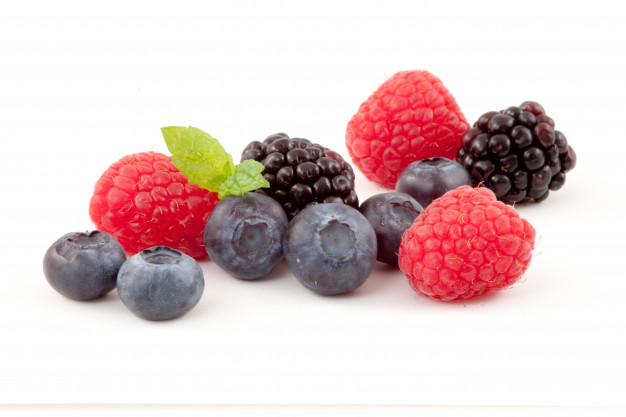

In [139]:
Image.open('/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg')

#### Other code

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

img_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

In [0]:
#features

#Image.open(img_path)

In [14]:
features.shape

(1, 7, 7, 512)

In [0]:
img_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg'

In [0]:
import tensorflow as tf
#img = read_file(img_path)
#img = image.load_img(img_path)
img = image.load_img(img_path, target_size=(224, 224))
#img = tf.image.decode_jpeg(img, channels=3)
#img = tf.image.resize(img, (299, 299))
#img = preprocess_input(img)
#features = model.predict(img)

In [38]:

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
print(x.shape)
features = model.predict(x)
features.shape

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


(1, 7, 7, 512)